In [63]:
import pandas as pd
import ipdb
import os

from tqdm import tqdm
from typing import Literal
from pydantic import BaseModel
from pathlib import Path

class Config(BaseModel):
    split:Literal['train','test','dev']
    BASEPATH : Path = Path("../data/")
    debug:bool = True

class Email2Table():
    
    def __init__(self,config:Config):
        self.config = config
        
        self.file_paths: List[str] = [ self.config.BASEPATH/self.config.split/name 
                                      for name in 
                                      os.listdir(self.config.BASEPATH/self.config.split)]
        
        self.emails: List[str] = [ open(self.file_paths[idx],'r').read().strip()\
                                    for idx in tqdm(range(len(self.file_paths)),
                                                    desc=f"Loading {self.config.split} Email") ]
    def split_email(self,email,file_name):
        if self.config.split == 'train':
            body,subject = email.split("@subject")
            if self.config.debug:
                ipdb.set_trace()
            out =  (file_name,
                body.strip(' \n'),
                subject.strip(' \n')
            )
            assert len(out)==3
            return out
        else:
            delimiters = ["@subject","@ann0","@ann1","@ann2"]
            st_idx = []
            for delimiter in delimiters:
                st_idx.append(email.find(delimiter))
            # This has the possibilty that it will break
            body = email[:st_idx[0]].strip(f" \n")
            subject = email[st_idx[0]:st_idx[1]].strip(f" \n{delimiters[0]}")
            annot0 = email[st_idx[1]:st_idx[2]].strip(f" \n{delimiters[1]}")
            annot1 = email[st_idx[2]:st_idx[3]].strip(f" \n{delimiters[2]}")
            annot2 = email[st_idx[3]:].strip(f" \n{delimiters[3]}")
            if self.config.debug:
                ipdb.set_trace()
            out = (file_name,
                    body.strip(' \n'),
                    subject.strip(' \n'),
                    annot0.strip(' \n'),
                    annot1.strip(' \n'),
                    annot2.strip(' \n')
            )
            assert len(out)==6
            return out
    
    def convert(self):
        table = []
        for idx in tqdm(range(len(self.emails)),desc=f"Converting :"):
            
            table.append(self.split_email(self.emails[idx],self.file_paths[idx].parts[-1]))
        cols = ["file_name","body","subject"]
        if self.config.split!='train':
            cols.extend(["ann0","ann1","ann2"])
        pd.DataFrame(table,columns=cols).to_csv(self.config.BASEPATH/
                                                f"{self.config.split}.csv")

In [64]:
for split in ['train','dev','test']:
    config = Config(split=split,debug=False)
    email2table = Email2Table(config)
    email2table.convert()

Converting :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1906/1906 [00:00<00:00, 87149.86it/s]


In [81]:
train = pd.read_csv('../data/train.csv')
dev = pd.read_csv('../data/dev.csv')
test = pd.read_csv('../data/test.csv')

In [82]:
len(test),len(dev),len(train)

(1906, 1960, 14436)

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
from typing import List
def plot_arr(arr:List,title:str):
    print(f"""
    Email: Min->{min(arr)} 
    Max->{max(arr)} 
    Average->{sum(arr)/len(arr)}""")
    sns.histplot(arr,kde=True)
    plt.title(title)
    plt.show()

def stastics_word_lenght(emails,subjects,annot0=None,annot1=None,annot2=None):
    pairs = [ (body,sub) for body,sub in zip(emails,subjects)]
    lenght_emails = []
    length_subjects = []
    
    for email,subject in pairs:
        lenght_emails.append( len(email.split()))
        length_subjects.append(len(subject.split()))
    
    plot_arr(arr=lenght_emails,title="Email Word Distribution")
    plot_arr(arr=length_subjects,title="Subject Word Distribution")
    
    if annot0 is not None:
        length_annot0 = [len(a.split()) for a in annot0]
        lenght_annot1 = [len(a.split()) for a in annot1]
        lenght_annot2 = [len(a.split()) for a in annot2]
        plot_arr(arr=length_annot0,title="Annot0 Word Distribution")
        plot_arr(arr=lenght_annot1,title="Annot1 Word Distribution")
        plot_arr(arr=lenght_annot2,title="Annot2 Word Distribution")


    Email: Min->25 
    Max->3136 
    Average->118.23136602937102


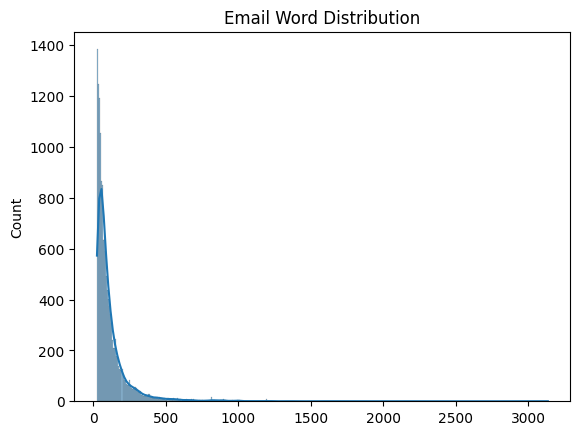


    Email: Min->1 
    Max->15 
    Average->3.9756857855361596


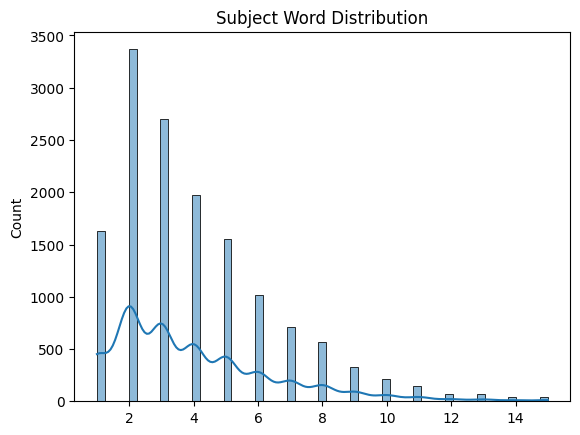

In [85]:
stastics_word_lenght(train['body'].tolist(),train['subject'].tolist())


    Email: Min->25 
    Max->2695 
    Average->124.4704081632653


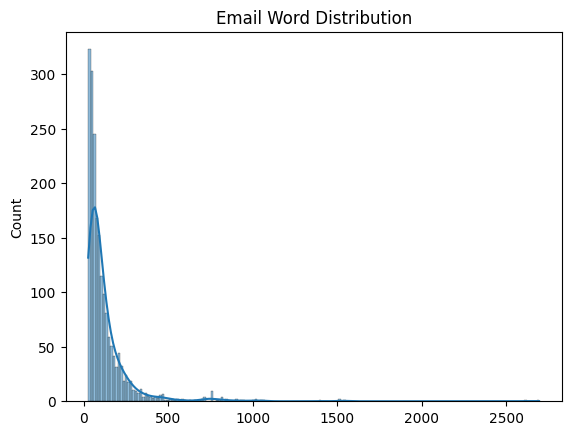


    Email: Min->1 
    Max->15 
    Average->4.100510204081632


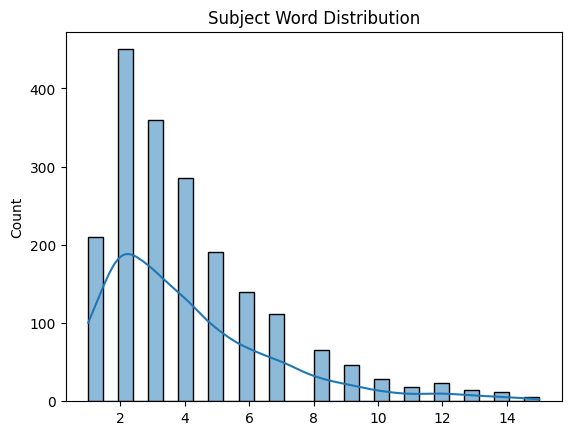


    Email: Min->1 
    Max->22 
    Average->4.716836734693878


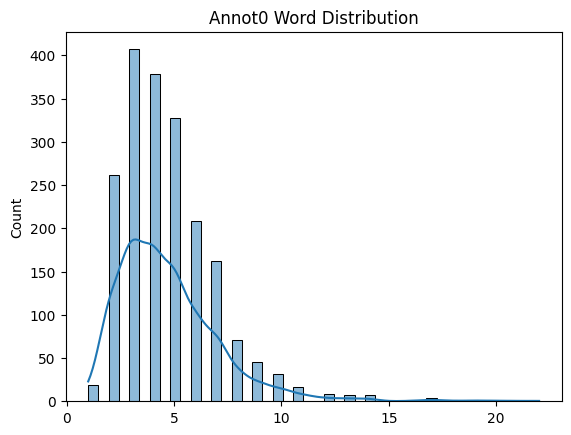


    Email: Min->1 
    Max->30 
    Average->5.039795918367347


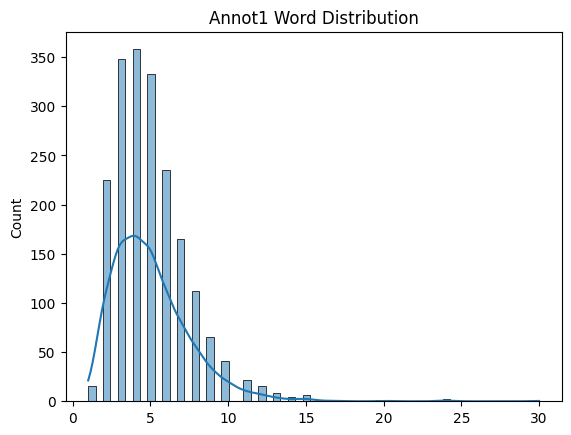


    Email: Min->1 
    Max->19 
    Average->4.914285714285715


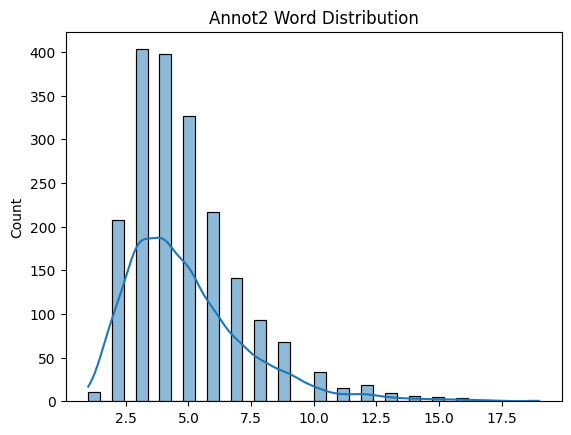

In [86]:
stastics_word_lenght(dev['body'].tolist(),dev['subject'].tolist(),
                     dev['ann0'].tolist(),dev['ann1'].tolist(),dev['ann2'].tolist())


    Email: Min->25 
    Max->1651 
    Average->114.58499475341029


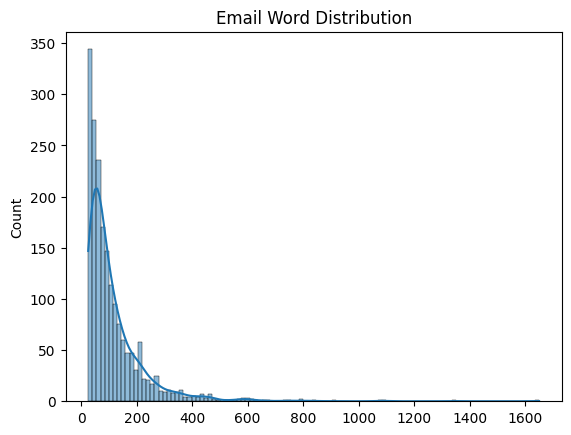


    Email: Min->1 
    Max->15 
    Average->4.078174186778594


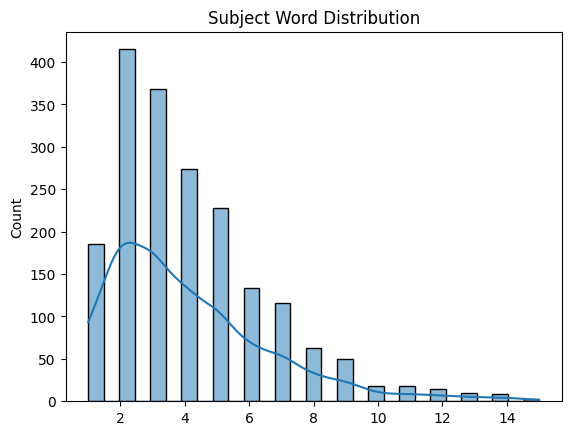


    Email: Min->1 
    Max->27 
    Average->4.8756558237145855


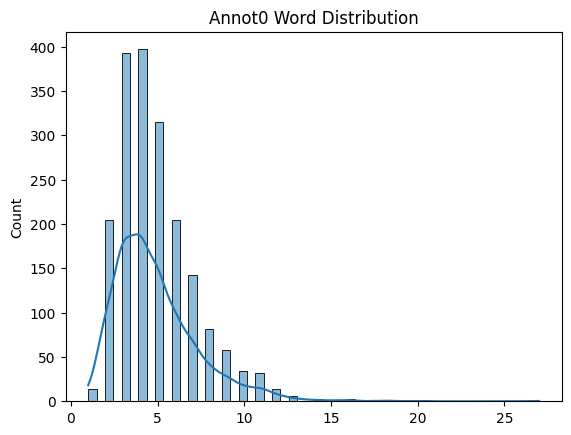


    Email: Min->1 
    Max->18 
    Average->5.052465897166842


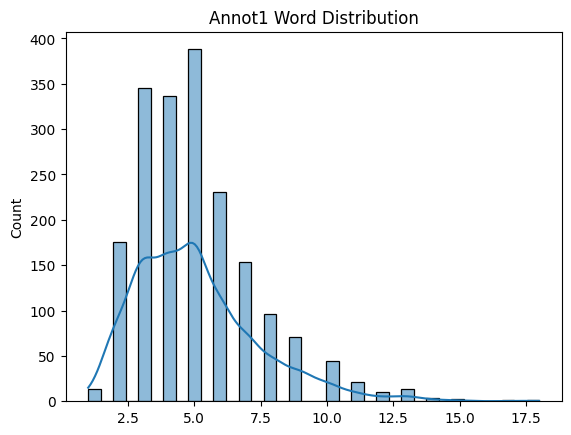


    Email: Min->1 
    Max->20 
    Average->4.979013641133263


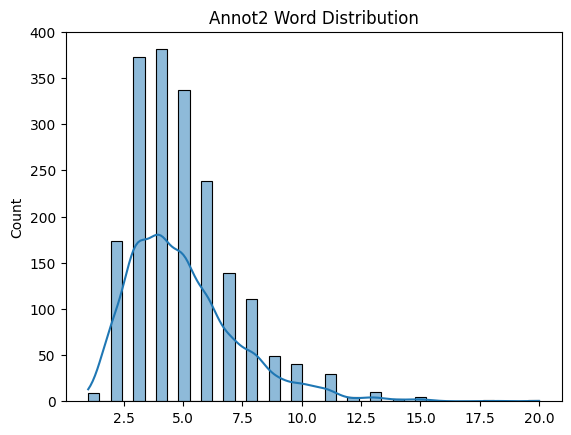

In [87]:
stastics_word_lenght(test['body'].tolist(),test['subject'].tolist(),
                     test['ann0'].tolist(),test['ann1'].tolist(),test['ann2'].tolist())

In [90]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [102]:
def rouge_cal(data,an1,an2):
    r1,r2,rl = 0,0,0
    counter = 0
    for a0,a1 in zip(data[an1].tolist(),data[an2].tolist()):
        scores = scorer.score(a0,a1)
        # print(scores)
        r1 += scores['rouge1'].fmeasure
        r2 += scores['rouge2'].fmeasure
        rl += scores['rougeL'].fmeasure
        counter+=1
    print(f"Between {an1} and {an2} the scores are :\n \
    Rouge-1 {r1/counter} Rouge-2 {r2/counter} Rouge-L {rl/counter}")

In [103]:
dev.columns

Index(['Unnamed: 0', 'file_name', 'body', 'subject', 'ann0', 'ann1', 'ann2'], dtype='object')

In [104]:
rouge_cal(dev,'ann0','ann2')

Between ann0 and ann2 the scores are :
     Rouge-1 0.3386203529252778 Rouge-2 0.16903890237552147 Rouge-L 0.32004677855426356


In [106]:
rouge_cal(dev,'ann2','ann1')

Between ann2 and ann1 the scores are :
     Rouge-1 0.3396461436660804 Rouge-2 0.16362942194222208 Rouge-L 0.3179645687736339


In [107]:
rouge_cal(dev,'ann0','ann1')

Between ann0 and ann1 the scores are :
     Rouge-1 0.33888096173716803 Rouge-2 0.16654932164071587 Rouge-L 0.32209396274014207


In [110]:
rouge_cal(dev,'subject','ann2')

Between subject and ann2 the scores are :
     Rouge-1 0.20906517668931718 Rouge-2 0.08125935068852183 Rouge-L 0.1975563209472369


In [111]:
rouge_cal(test,'ann0','ann2')

Between ann0 and ann2 the scores are :
     Rouge-1 0.33885518962838407 Rouge-2 0.16273811287697568 Rouge-L 0.3184625425884464


In [112]:
rouge_cal(test,'ann0','ann1')

Between ann0 and ann1 the scores are :
     Rouge-1 0.3469570732734676 Rouge-2 0.17485430440518518 Rouge-L 0.32688980712601134


In [113]:
rouge_cal(test,'ann1','ann2')

Between ann1 and ann2 the scores are :
     Rouge-1 0.35149804539264723 Rouge-2 0.17312230014782354 Rouge-L 0.32873476148287806


In [114]:
rouge_cal(test,'subject','ann2')

Between subject and ann2 the scores are :
     Rouge-1 0.2077422493367065 Rouge-2 0.08150122436976803 Rouge-L 0.1988860097759213
